In [38]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['LANGSMITH_TRACING'] = "true"

In [39]:
from langchain.chat_models import init_chat_model
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore


model = init_chat_model("llama-3.3-70b-versatile", model_provider="groq")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = InMemoryVectorStore(embeddings)

In [40]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)

loader = WebBaseLoader("https://www.bionomina.com/")
docs = loader.load()

all_splits = text_splitter.split_documents(docs)

print(f"chunks {len(all_splits)}")

document_ids = vector_store.add_documents(documents=all_splits)



chunks 6


In [41]:

from langchain_core.prompts import PromptTemplate

template = """"You are a highly skilled sales representative specializing in analyzing marketing materials and 
generating persuasive sales pitches.

**Task 1: Context Analysis**

You will be provided with a piece of retrieved context. Carefully analyze this context to:

* **Identify all products and services mentioned.**
* **Determine the primary marketing goals.**
* **Pinpoint the intended call to action.**

**Task 2: Sales Pitch Generation**

When prompted to generate a sales pitch, use the information extracted from the context analysis to create an 
engaging and compelling pitch. This pitch should:

* Directly address the identified marketing goals.
* Clearly and persuasively guide the potential buyer towards the call to action.
* Highlight the benefits of the products or services.

**Task 3: Responding to Inquiries**

* If asked questions related to the provided context, respond accurately and thoroughly, actively or 
passively incorporating sales-oriented language to promote the products or services.
* If asked questions unrelated to the provided context, politely state, 
"I apologize, but I can only assist with inquiries related to our product and services."

**Instructions:**

* Maintain a professional and enthusiastic tone.
* Be concise and focused in your responses.
* Prioritize driving the user towards the desired call to action.
* Clearly seperate the different sections of your analysis if you are asked to show the analysis.
* Always answer in the language of the context

**Context:**

{context}

**Example Interaction:**

**User:** "What are the key products and services?"
**LLM:** "[Analysis of products/services]... These products/services are designed to 
[mention key benefits and tie it to the marketing goals] and are available if you [mention call to action]"

**User:** "Generate a sales pitch."
**LLM:** "[Generated sales pitch, incorporating marketing goals and call to action]"

**User:** "What is the weather today?"
**LLM:** "I apologize, but I can only assist with inquiries related to our product and services."


Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

print(custom_rag_prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} template='"You are a highly skilled sales representative specializing in analyzing marketing materials and \ngenerating persuasive sales pitches.\n\n**Task 1: Context Analysis**\n\nYou will be provided with a piece of retrieved context. Carefully analyze this context to:\n\n* **Identify all products and services mentioned.**\n* **Determine the primary marketing goals.**\n* **Pinpoint the intended call to action.**\n\n**Task 2: Sales Pitch Generation**\n\nWhen prompted to generate a sales pitch, use the information extracted from the context analysis to create an \nengaging and compelling pitch. This pitch should:\n\n* Directly address the identified marketing goals.\n* Clearly and persuasively guide the potential buyer towards the call to action.\n* Highlight the benefits of the products or services.\n\n**Task 3: Responding to Inquiries**\n\n* If asked questions related to the provided context, respond accurate

In [42]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict, Annotated

class Search(TypedDict):
    """Search Query."""

    query: Annotated[str, ..., "Search query ro run."]

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

In [43]:
def analyze_query(state:State):
    structured_llm = model.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state=State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],    
    )
    return { "context" : retrieved_docs}

def generate(state: State):
    docs_content ="\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


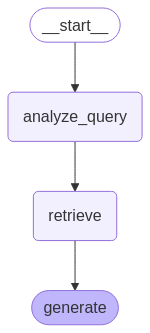

In [44]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve,generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
for step in graph.stream(
    {"question": "por favor, Genera la sales pitch "}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'sales pitch examples'}}}

----------------

{'retrieve': {'context': [Document(id='3e1c3fad-916f-4394-9038-bdd15a44c8e8', metadata={'source': 'https://www.bionomina.com/', 'title': 'Software en la Nube para Control de Asistencia del Personal - Bionómina', 'description': 'Software en la Nube para control de asistencia del personal. Control Biométrico centralizado de Asistencia (Rondas, Horas, Sobretiempos, Permisos).', 'language': 'No language found.', 'start_index': 2950}, page_content='BioNómina en números:\n\n\n+5000\n\n\n\n\nTrabajadores supervisados\n\n\n\n+100\n\n\n\n\nSucursales supervisadas\n\n\n\n100%\n\n\n\n\nSatisfacción\n\n\n\n\n\nSolicite una Llamada Telefónica…\n\n\n\n\n\n\n¿Le gustaría hablar con alguno de nuestros consultores? Sólo complete el formulario de la derecha y lo contacteremos en la mayor brevedad posible.\nNota: Los datos que suministre por esta vía se mantendrán estrictamente confidenciales de acuerdo a nuestra Política 